In [1]:
par_log_transform = True

In [2]:
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
from utils.my_plotting_lib import plot_barcodes, plot_conf_ellipse
from utils.fim_utils import computeCriteria, logTransform
rc('text', usetex=True)

In [3]:
with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/bursting_parameters.npz') as par:
    kon = par['kon']
    koff = par['koff']
    alpha = par['alpha']
    gamma = par['gamma']

theta = np.array([kon, koff, alpha, gamma])

In [4]:
fim_single_cell = dict()

for s in ["exact", "binomial", "lowres"]:
    with np.load(f'results/fim_{s}.npz') as data:
        fim_single_cell[s] = data['fim']

if par_log_transform:
    for fim in fim_single_cell.values():
        logTransform(fim, theta)

## Monte Carlo estimates for flowcytometry FIM

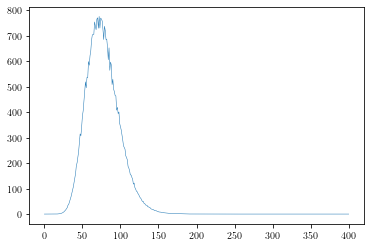

In [5]:
with np.load(f'results/fim_flowcyt.npz') as _:
    fim_flowcyts = _['fim']
fig = plt.figure()
ax = fig.add_subplot()
for i in range(fim_flowcyts.shape[0]):
    y = computeCriteria(fim_flowcyts[i, ...])
    ax.plot(y, linewidth=0.5)
fim_flowcyt = np.mean(fim_flowcyts, axis=0)
y = computeCriteria(fim_flowcyt)
logTransform(fim_flowcyt, theta)
fim_single_cell["flowcyt"] = fim_flowcyt

## D-optimal sampling periods for different types of measurements

Optimal sampling period for exact is 30 min with D-opt=5.604839190846351e+17.
Optimal sampling period for binomial is 29 min with D-opt=1.5490331129052573e+17.
Optimal sampling period for lowres is 33 min with D-opt=2.894352933772735e+16.
Optimal sampling period for flowcyt is 26 min with D-opt=1.0624957638850894e+17.


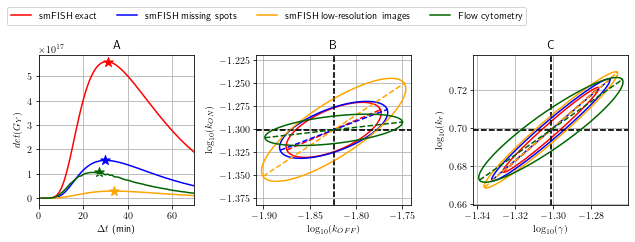

In [25]:
ncells_smfish = 1000
ncells_flowcyt = 5000

fim_multi_cells = dict()

for meas_type in fim_single_cell.keys():
    fim_multi_cells[meas_type] = ncells_smfish*fim_single_cell[meas_type]
fim_multi_cells['flowcyt'] = ncells_flowcyt*fim_single_cell['flowcyt']

def compute_combined_fim(fim_array, dt, num_times):
    t_idx = dt*np.linspace(1, num_times, num_times, dtype=int)
    fim = fim_array[t_idx[0], :, :]
    for i in range(1, len(t_idx)):
        fim += fim_array[t_idx[i], :, :]
    return fim

num_times = 5
dt_min = 1
dt_max = int(np.floor(t_meas[-1]/num_times))
dt_array = np.linspace(dt_min, dt_max, dt_max - dt_min +1, dtype=int)

fim_multi_cells_times = dict()
det_fim_multi_cells_times = dict()

for meas_type in fim_multi_cells.keys():
    combined_fim = np.zeros((len(dt_array), 4, 4))
    det_comb_fim = np.zeros((len(dt_array),))

    for i in range(0, len(dt_array)):
        combined_fim[i, :, :] = compute_combined_fim(fim_multi_cells[meas_type], dt_array[i],  num_times)
        det_comb_fim[i] = np.linalg.det(combined_fim[i,:,:])

    fim_multi_cells_times[meas_type] = combined_fim
    det_fim_multi_cells_times[meas_type] = det_comb_fim
#
opt_rates = dict()
for meas in fim_multi_cells_times.keys():
    opt_rates[meas] = np.argmax(det_fim_multi_cells_times[meas])
    print(f"Optimal sampling period for {meas} is {opt_rates[meas]} "
          f"min with D-opt={det_fim_multi_cells_times[meas][opt_rates[meas]]}.")

DT_MAX = 70
labels = {
        'exact': f'smFISH exact',
        'binomial': f'smFISH missing spots',
        'lowres': f'smFISH low-resolution images',
        'flowcyt': f'Flow cytometry',
}

colors = {
        'exact': f'red',
        'binomial': f'blue',
        'lowres': f'orange',
        'flowcyt': f'darkgreen',
}
    
fig, axs = plt.subplots(1,3)
fig.set_size_inches(9, 3)
fig.set_tight_layout(True)
for meas in ['exact', 'binomial', 'lowres', 'flowcyt']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    
    axs[0].plot(dt_array, dets, label=labels[meas], color=colors[meas])
    axs[0].scatter(dt_array[idx_opt],
                   dets[idx_opt],
               100,
               color=colors[meas],
                   marker='*')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[1],
                      [1,0],
                      theta,
                      colors[meas], '')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[2],
                      [3,2],
                      theta, colors[meas], '')

h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower left', ncol=5)
axs[0].set_xlim([0, DT_MAX])
axs[0].set_xlabel('$\Delta t$ (min)')
axs[0].set_ylabel('$\mathop{det}(G_Y)$')

for j in range(1, 3):
    axs[j].set_aspect('equal', 'datalim')
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')    
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')    
axs[2].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs):
    ax.grid()

axs[0].set_title('A')
axs[1].set_title('B')
axs[2].set_title('C')

fig.savefig('figs/fim_dopt.pdf', bbox_inches='tight')

## Find the optimal mixture of smFISH and flow cytomtery experiments at the optimal sampling period of exact smFISH
Could we further improve the precision of smFISH-based estimates by mixing in some flow-cytometry measurements?

In [20]:
BUDGET_MAX = 1000.0
SMFISH_COST = 1
FLOWCYT_COST = 0.2

DT_OPT = opt_rates["exact"] # Optimze the previous design at the optimal rate of exact smFISH

CRITERIA = "d"

m_flowcyt = np.copy(fim_single_cell["flowcyt"][DT_OPT,...])
m_fish = np.copy(fim_single_cell["exact"][DT_OPT,...])
for i in range(1,5):
    m_flowcyt += fim_single_cell["flowcyt"][i*DT_OPT,...]
    m_fish += fim_single_cell["exact"][i*DT_OPT,...]

obj_values = np.zeros(
    (int(BUDGET_MAX/SMFISH_COST)+1,
     int(BUDGET_MAX/FLOWCYT_COST)+1
     )
)
for nfish in range(obj_values.shape[0]):
    for nflowcyt in range(1+int((BUDGET_MAX-nfish*SMFISH_COST)/FLOWCYT_COST)):
        obj_values[nfish, nflowcyt] = computeCriteria(nfish*m_fish + nflowcyt*m_flowcyt,
                                                      criteria=CRITERIA)
opt_mixture = np.unravel_index(np.argmax(obj_values), obj_values.shape)
fim_mix_opt = opt_mixture[0]*m_fish + opt_mixture[1]*m_flowcyt

print(f"""
      The optimal mixture is {opt_mixture[0]} smFISH and
      {opt_mixture[1]} flow-cytomtery measurements with D-opt value {np.max(obj_values)}.
      """)


      The optimal mixture is 756 smFISH and
      1220 flow-cytomtery measurements with D-opt value 6.048145308199855e+17.
      


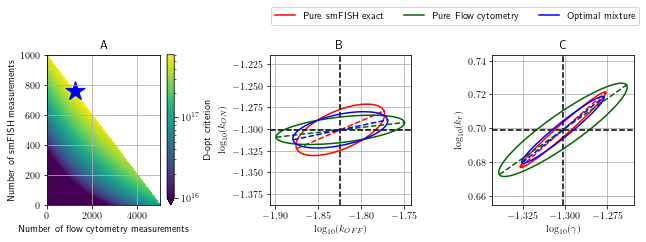

In [41]:
import matplotlib.colors as Colors

fig, axs = plt.subplots(1,3)
fig.set_size_inches(9, 3)
fig.set_tight_layout(True)

mixture_plot = axs[0].pcolorfast(obj_values, norm=Colors.LogNorm(vmin=1.0E16, vmax=6E17))
fig.colorbar(mixture_plot, ax=axs[0], orientation='vertical', extend='min',
             label=r"D-opt criterion")
axs[0].scatter(opt_mixture[1], opt_mixture[0], 400, marker='*', color="blue")
axs[0].set_xlabel("Number of flow cytometry measurements")
axs[0].set_ylabel("Number of smFISH measurements")

for meas in ['exact', 'flowcyt']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]

    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[1],
                      [1,0],
                      theta,
                      colors[meas], f'Pure {labels[meas]}')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[2],
                      [3,2],
                      theta, colors[meas], f'Pure {meas}')
plot_conf_ellipse(fim_mix_opt,
                      3,
                      axs[1],
                      [1,0],
                      theta,
                      'blue', 'Optimal mixture')
plot_conf_ellipse(fim_mix_opt,
                  3,
                  axs[2],
                  [3,2],
                  theta, 'blue', 'Optimal mixture')

h, l = axs[1].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower right', ncol=5)

for j in range(1, 3):
    axs[j].set_aspect('equal', 'datalim')
    axs[j].grid()
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')
axs[2].set_xlabel('$\log_{10}({\gamma})$')
axs[0].grid()
axs[0].set_title('A')
axs[1].set_title('B')
axs[2].set_title('C')
fig.savefig("figs/mixture_dopt.png", dpi=300, bbox_inches="tight")

## Heatmaps for the probability kernels

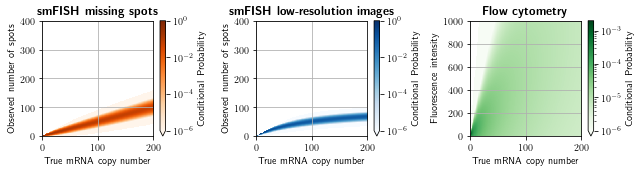

In [9]:
pdos = {}
for s in ["binomial", "lowres", "flowcyt"]:
    with np.load(f'results/distortion_matrix_{s}.npz') as data:
        pdos[s] = data['C']
pdo_colors = ["Oranges", "Blues", "Greens"]

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(9, 2.5)
fig.set_tight_layout(True)

for i,s in enumerate(pdos.keys()):
    C = pdos[s][:, :200]
    p = axs[i].pcolorfast(C, norm=colors.LogNorm(vmin=1.0E-6),
                         cmap=plt.cm.get_cmap(pdo_colors[i]))
    fig.colorbar(p, ax=axs[i], orientation='vertical', extend='min', label=r"Conditional Probability")

for j in range(0,3):
    axs[j].set_xlabel('True mRNA copy number')
    axs[j].set_ylabel('Observed number of spots')
axs[2].set_ylabel('Fluorescence intensity')

models = ['smFISH missing spots', 'smFISH low-resolution images', 'Flow cytometry']
for j in range(0,3):
    axs[j].set_title(rf'\textbf{{{models[j]}}}')
    axs[j].grid()

fig.savefig('figs/kernel_maps.png', bbox_inches='tight', dpi=200)

